In [16]:
import os
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

In [19]:
import kagglehub
path = kagglehub.dataset_download("msambare/fer2013")

## Simple CNN Model

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


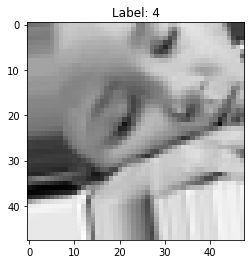

In [23]:
# Set paths
base_dir = "/Users/danielarday/.cache/kagglehub/datasets/msambare/fer2013/versions/1"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Verify dataset exists
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Train or Test directory not found. Please check the dataset.")

# Define ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,  
    rotation_range=20,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting train into train/validation
)

# Load images using ImageDataGenerator
batch_size = 64
img_size = (48, 48)

# Load images from directories
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Print class labels
print("Class Labels:", train_generator.class_indices)

# Example: Get a batch of images
images, labels = next(train_generator)
plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Label: {np.argmax(labels[0])}")
plt.show()


Epoch 1/25
359/359 [==============================] - 108s 297ms/step - loss: 2.0114 - accuracy: 0.2316 - val_loss: 2.2282 - val_accuracy: 0.1749
Epoch 2/25


/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 94s 262ms/step - loss: 1.7839 - accuracy: 0.2662 - val_loss: 1.7448 - val_accuracy: 0.2850
Epoch 3/25
359/359 [==============================] - 95s 263ms/step - loss: 1.7104 - accuracy: 0.3109 - val_loss: 1.7872 - val_accuracy: 0.2970
Epoch 4/25
359/359 [==============================] - 95s 266ms/step - loss: 1.6480 - accuracy: 0.3459 - val_loss: 1.6242 - val_accuracy: 0.3398
Epoch 5/25
359/359 [==============================] - 95s 264ms/step - loss: 1.5790 - accuracy: 0.3744 - val_loss: 1.8844 - val_accuracy: 0.2353
Epoch 6/25
359/359 [==============================] - 97s 269ms/step - loss: 1.5293 - accuracy: 0.4023 - val_loss: 1.5616 - val_accuracy: 0.3841
Epoch 7/25
359/359 [==============================] - 98s 273ms/step - loss: 1.4833 - accuracy: 0.4266 - val_loss: 1.5621 - val_accuracy: 0.3830
Epoch 8/25
359/359 [==============================] - 99s 274ms/step - loss: 1.4454 - accuracy: 0.4424 - val_loss: 1.4687 - val_accuracy: 0.4

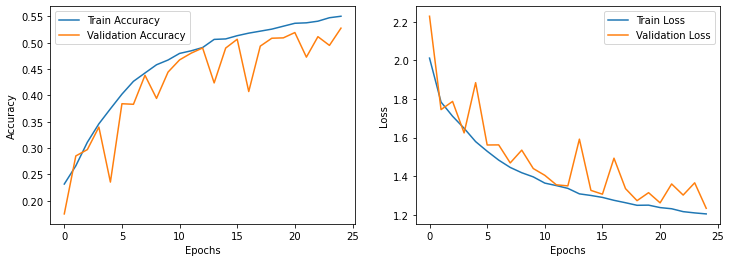

In [24]:
# Get the number of classes dynamically
num_classes = len(train_generator.class_indices)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping & Model Checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("fer_best_model.h5", save_best_only=True)
]

# Train Model using train_generator and val_generator
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks
)

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


113/113 [==============================] - 10s 84ms/step
              precision    recall  f1-score   support

       angry       0.36      0.64      0.46       958
     disgust       0.00      0.00      0.00       111
        fear       0.38      0.18      0.24      1024
       happy       0.83      0.78      0.80      1774
     neutral       0.46      0.68      0.55      1233
         sad       0.49      0.30      0.37      1247
    surprise       0.75      0.65      0.70       831

    accuracy                           0.55      7178
   macro avg       0.47      0.46      0.45      7178
weighted avg       0.56      0.55      0.53      7178



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


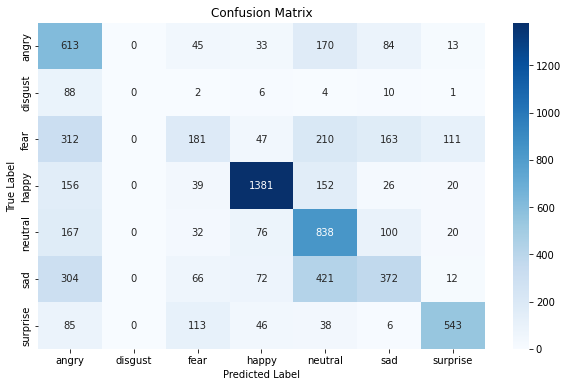

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator)  # Probabilities
y_pred_classes = y_pred.argmax(axis=1)  # Convert to class labels

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [27]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

113/113 [==============================] - 10s 85ms/step - loss: 1.1722 - accuracy: 0.5472
Test Accuracy: 0.5472


#### Brief Analysis

- Happy (78%) & Surprise (65%) were classified well.
- Fear (18%), Sad (30%), and Angry (64%) had poor recall.
- Disgust (0%) is not predicted at all (likely due to very few samples).

## Transfer Learning Model ( EfficientNetB0 )

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze base model (so only new layers train initially)
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replaces Flatten()
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)  # num_classes from train_generator.class_indices

# Create final model
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

# Train only the top layers first
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

# Unfreeze the base model and fine-tune everything
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=callbacks)

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 48, 48, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

                                                                                                  
 block2a_se_excite (Multipl  (None, 12, 12, 96)           0         ['block2a_activation[0][0]',  
 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 12, 12, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 12, 12, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_e

 block3a_se_excite (Multipl  (None, 6, 6, 144)            0         ['block3a_activation[0][0]',  
 y)                                                                  'block3a_se_expand[0][0]']   
                                                                                                  
 block3a_project_conv (Conv  (None, 6, 6, 40)             5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 6, 6, 40)             160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 6, 6, 240)            9600      ['block3a_project_bn[0][0]']  
 D)       

 y)                                                                  'block4a_se_expand[0][0]']   
                                                                                                  
 block4a_project_conv (Conv  (None, 3, 3, 80)             19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 3, 3, 80)             320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 3, 3, 480)            38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block4c_project_bn (BatchN  (None, 3, 3, 80)             320       ['block4c_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 3, 3, 80)             0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 3, 3, 80)             0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 3, 3, 480)            38400     ['block4c_add[0][0]']         
 D)       

 block5b_drop (Dropout)      (None, 3, 3, 112)            0         ['block5b_project_bn[0][0]']  
                                                                                                  
 block5b_add (Add)           (None, 3, 3, 112)            0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 3, 3, 672)            75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 3, 3, 672)            2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6a_project_bn (BatchN  (None, 2, 2, 192)            768       ['block6a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 2, 2, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 2, 2, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_e

 block6c_drop (Dropout)      (None, 2, 2, 192)            0         ['block6c_project_bn[0][0]']  
                                                                                                  
 block6c_add (Add)           (None, 2, 2, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 2, 2, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 2, 2, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 top_conv (Conv2D)           (None, 2, 2, 1280)           409600    ['block7a_project_bn[0][0]']  
                                                                                                  
 top_bn (BatchNormalization  (None, 2, 2, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 2, 2, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['top_activation[0][0]']      
 GlobalAve

## ResNet

Images need to be in RGB for ResNet

In [32]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="rgb",  # Change from "grayscale" to "rgb"
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="rgb",  # Change from "grayscale" to "rgb"
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="rgb",  # Change from "grayscale" to "rgb"
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [33]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze base model (so only new layers train initially)
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replaces Flatten()
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)  # num_classes from train_generator.class_indices

# Create final model
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()

# Train only the top layers first
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

# Unfreeze the base model and fine-tune everything
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=callbacks)

# Evaluate Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 12, 12, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 12, 12, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 12, 12, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 6, 6, 512)            66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 6, 6, 512)            2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 6, 6, 512)            0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 3, 3, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 3, 3, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 3, 3, 256)            0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 3, 3, 1024)           525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 3, 3, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 3, 3, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 3, 3, 256)            1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 3, 3, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 3, 3, 1024)           0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 3, 3, 1024)           0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 2, 2, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 2, 2, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


359/359 [==============================] - 532s 1s/step - loss: 1.1753 - accuracy: 0.5569 - val_loss: 1.2150 - val_accuracy: 0.5348
Epoch 7/15
359/359 [==============================] - 529s 1s/step - loss: 1.1379 - accuracy: 0.5715 - val_loss: 1.2011 - val_accuracy: 0.5424
Epoch 8/15
359/359 [==============================] - 533s 1s/step - loss: 1.1062 - accuracy: 0.5814 - val_loss: 1.1741 - val_accuracy: 0.5574
Epoch 9/15
359/359 [==============================] - 530s 1s/step - loss: 1.0935 - accuracy: 0.5882 - val_loss: 1.1758 - val_accuracy: 0.5569
Epoch 10/15
359/359 [==============================] - 535s 1s/step - loss: 1.0580 - accuracy: 0.6041 - val_loss: 1.2284 - val_accuracy: 0.5569
Epoch 11/15
359/359 [==============================] - 537s 1s/step - loss: 1.0413 - accuracy: 0.6102 - val_loss: 1.1369 - val_accuracy: 0.5799
Epoch 12/15
359/359 [==============================] - 19329s 54s/step - loss: 1.0135 - accuracy: 0.6210 - val_loss: 1.1776 - val_accuracy: 0.5720
Epoc